In [11]:
import datasets
import torch
import transformers

print(datasets.__version__, transformers.__version__, torch.__version__)

import torch
import torch.nn as nn
from tqdm.auto import tqdm

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

# make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

2.16.1 4.36.2 1.13.1+cu117
cuda


In [12]:
import datasets

### 1. Load Dataset - Modified for Hate Speech
raw_datasets = datasets.load_dataset("wisnu001binus/Hate_Speech_Dataset")
# Print dataset info
print("Dataset structure:", raw_datasets)
print("Dataset columns:", raw_datasets["train"].column_names)

# Get label information
num_labels = len(set(raw_datasets["train"]["Label"]))
label_list = sorted(list(set(raw_datasets["train"]["Label"])))
label2id = {v: i for i, v in enumerate(label_list)}
id2label = {i: v for v, i in label2id.items()}

print(f"Number of labels: {num_labels}")
print("Label mapping:", label2id)

from transformers import AutoModelForSequenceClassification, AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)


def tokenize_function(examples):
    """Modified tokenization function for hate speech dataset"""
    return tokenizer(
        examples["Content"],  # Use the text column from the hate speech dataset
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )


# Tokenize datasets
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Remove unnecessary columns and rename label column
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in raw_datasets["train"].column_names if col != "Label"]
)
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
tokenized_datasets.set_format("torch")

# Create smaller datasets for faster training
small_train_dataset = (
    tokenized_datasets["train"].shuffle(seed=SEED).select(range(10000))
)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(1000))

from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator
)

# Verify the data loading
for batch in train_dataloader:
    print("Batch shapes:", {k: v.shape for k, v in batch.items()})
    break

Repo card metadata block was not found. Setting CardData to empty.


Dataset structure: DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 580895
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 145224
    })
})
Dataset columns: ['Content', 'Label']
Number of labels: 2
Label mapping: {0: 0, 1: 1}


c:\Users\silan\Desktop\A7\.venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch shapes: {'labels': torch.Size([32]), 'input_ids': torch.Size([32, 128]), 'token_type_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128])}


In [13]:
teacher_model.config

from transformers.models.bert.modeling_bert import BertConfig

# Get teacher configuration as a dictionary
configuration = teacher_model.config.to_dict()

# Half the number of hidden layers
configuration["num_hidden_layers"] //= 2
# Convert the dictionary to the student configuration
configuration = BertConfig.from_dict(configuration)

# Create uninitialized student model
model = type(teacher_model)(configuration)

from torch.nn import Module
from transformers.models.bert.modeling_bert import BertEncoder, BertModel


def distill_bert_weights(
    teacher: Module, student: Module, use_odd_layers: bool = True
) -> Module:
    """
    Recursively copies the weights of the teacher to the student.
    Args:
        teacher: The teacher model
        student: The student model
        use_odd_layers: If True, copy odd-numbered layers; if False, copy even-numbered layers
    Returns:
        The initialized student model
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith("BertFor"):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, use_odd_layers)
    # Else if the part is an encoder, copy selected layers
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [
            layer for layer in next(teacher.children())
        ]  # 12 layers
        student_encoding_layers = [
            layer for layer in next(student.children())
        ]  # 6 layers
        for i in range(len(student_encoding_layers)):
            source_idx = 2 * i + (
                1 if use_odd_layers else 0
            )  # Select odd or even layers
            student_encoding_layers[i].load_state_dict(
                teacher_encoding_layers[source_idx].state_dict()
            )
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
# Create and initialize two student models
model_odd = type(teacher_model)(configuration)
model_even = type(teacher_model)(configuration)

# Initialize with odd and even layers respectively
model_odd = distill_bert_weights(teacher_model, model_odd, use_odd_layers=True)
model_even = distill_bert_weights(teacher_model, model_even, use_odd_layers=False)

# Print model sizes for comparison
print("Teacher parameters:", count_parameters(teacher_model))
print("Student (odd) parameters:", count_parameters(model_odd))
print("Student (even) parameters:", count_parameters(model_even))

# Calculate and print the compression ratio
compression_ratio = count_parameters(model_odd) / count_parameters(teacher_model) * 100
print(f"Compression ratio: {compression_ratio:.2f}%")

Teacher parameters: 109483778
Student (odd) parameters: 66956546
Student (even) parameters: 66956546
Compression ratio: 61.16%


In [15]:
# Loss functions for knowledge distillation
import torch.nn.functional as F


class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        """
        Note: the output_student and output_teacher are logits
        """
        T = temperature

        KD_loss = (
            nn.KLDivLoss(reduction="batchmean")(
                F.log_softmax(output_student / T, dim=-1),
                F.softmax(output_teacher / T, dim=-1),
            )
            * T
            * T
        )
        return KD_loss


# Initialize loss functions
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

In [16]:
import torch.nn as nn
import torch.optim as optim

lr = 5e-5

# training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = model.to(device)
teacher_model = teacher_model.to(device)

from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


# Training setup for both models
def setup_training(model):
    optimizer = optim.Adam(params=model.parameters(), lr=5e-5)
    model = model.to(device)

    num_epochs = 5
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_epochs * num_update_steps_per_epoch

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    return optimizer, lr_scheduler


# Setup training for both models
optimizer_odd, scheduler_odd = setup_training(model_odd)
optimizer_even, scheduler_even = setup_training(model_even)

# Move teacher model to device
teacher_model = teacher_model.to(device)


import evaluate
import numpy as np

# Get the metric function
# if task_name is not None:
    # metric = evaluate.load("glue", task_name)
# else:
metric = evaluate.load("accuracy")

In [17]:
import torch

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model(**batch)
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()

        # cls loss
        loss_cls = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(
            output_teacher.logits,
            outputs.logits,
            torch.ones(output_teacher.logits.size()[0]).to(device),
        )
        train_loss_cos += loss_cos.item()

        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3

        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f"Epoch at {epoch + 1}: Train loss {train_loss / len(train_dataloader):.4f}:")
    print(f"  - Loss_cls: {train_loss_cls / len(train_dataloader):.4f}")
    print(f"  - Loss_div: {train_loss_div / len(train_dataloader):.4f}")
    print(f"  - Loss_cos: {train_loss_cos / len(train_dataloader):.4f}")

    model.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(predictions=predictions, references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric["accuracy"]
    eval_losses.append(
        eval_loss / len(eval_dataloader)
    )  # Save the evaluation loss for plotting

    print(f"Epoch at {epoch + 1}: Test Acc {eval_metric['accuracy']:.4f}")

print("Avg Metric", eval_metrics / num_epochs)

  0%|          | 0/1565 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2483:
  - Loss_cls: 0.6804
  - Loss_div: 0.0194
  - Loss_cos: 0.0450
Epoch at 1: Test Acc 0.7430
Epoch at 2: Train loss 0.2167:
  - Loss_cls: 0.5464
  - Loss_div: 0.0569
  - Loss_cos: 0.0467
Epoch at 2: Test Acc 0.7430
Epoch at 3: Train loss 0.1979:
  - Loss_cls: 0.4632
  - Loss_div: 0.0839
  - Loss_cos: 0.0465
Epoch at 3: Test Acc 0.7850
Epoch at 4: Train loss 0.1873:
  - Loss_cls: 0.4150
  - Loss_div: 0.1002
  - Loss_cos: 0.0467
Epoch at 4: Test Acc 0.7850
Epoch at 5: Train loss 0.1807:
  - Loss_cls: 0.3861
  - Loss_div: 0.1096
  - Loss_cos: 0.0464
Epoch at 5: Test Acc 0.7840
Avg Metric 0.768


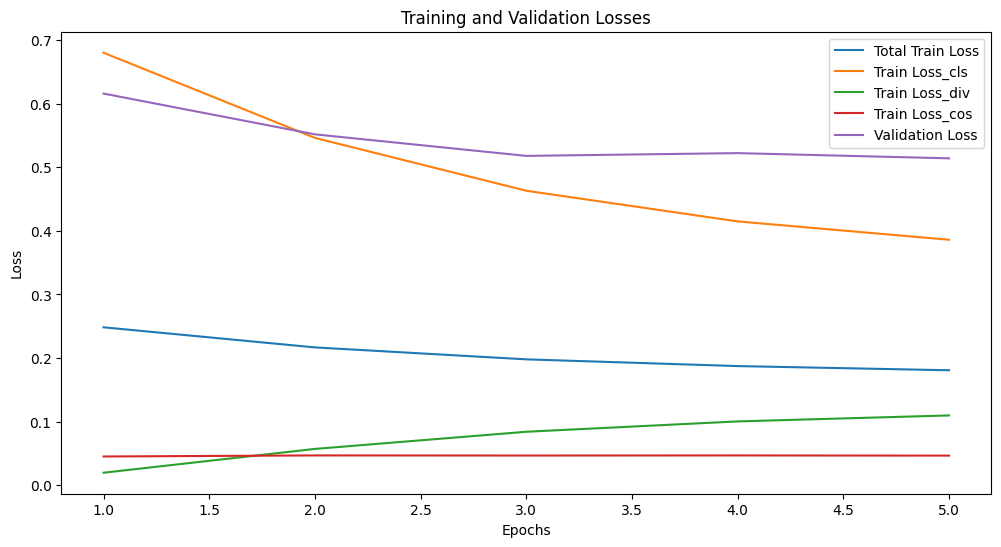

In [18]:
import matplotlib.pyplot as plt

# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label="Total Train Loss")
plt.plot(epochs_list, train_losses_cls, label="Train Loss_cls")
plt.plot(epochs_list, train_losses_div, label="Train Loss_div")
plt.plot(epochs_list, train_losses_cos, label="Train Loss_cos")
plt.plot(epochs_list, eval_losses, label="Validation Loss")

plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# Import LoRA-related modules
from peft import LoraConfig, TaskType, get_peft_model

# Create LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,  # rank of LoRA
    lora_alpha=32,  # alpha scaling
    lora_dropout=0.1,
    target_modules=["query", "value"],  # Apply LoRA to attention layers
    bias="none",
)

# Create LoRA model
model_lora = type(teacher_model)(configuration)  # Create base 6-layer model
model_lora = get_peft_model(model_lora, peft_config)
print("LoRA parameters:", count_parameters(model_lora))

# Setup training for LoRA model
optimizer_lora, scheduler_lora = setup_training(model_lora)

LoRA parameters: 296450


In [20]:
# Training function for all models
def train_model(model, optimizer, scheduler, model_name="Model"):
    """
    Training function that works for all model variants
    """
    model.train()
    teacher_model.eval()
    
    train_losses = []
    eval_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        progress_bar = tqdm(range(len(train_dataloader)))
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get model outputs
            outputs = model(**batch)
            with torch.no_grad():
                teacher_outputs = teacher_model(**batch)
            
            # Calculate losses
            loss_cls = outputs.loss
            loss_div = criterion_div(outputs.logits, teacher_outputs.logits)
            loss_cos = criterion_cos(
                teacher_outputs.logits,
                outputs.logits,
                torch.ones(outputs.logits.size()[0]).to(device)
            )
            
            # Combined loss
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            progress_bar.update(1)
        
        avg_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        
        # Evaluation
        model.eval()
        eval_accuracy = 0
        
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            
            predictions = outputs.logits.argmax(dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])
        
        eval_metric = metric.compute()
        eval_accuracies.append(eval_metric["accuracy"])
        
        print(
            f"{model_name} - Epoch {epoch + 1}: "
            f"Train Loss: {avg_loss:.4f}, "
            f"Eval Accuracy: {eval_metric['accuracy']:.4f}"
        )
    
    return train_losses, eval_accuracies

In [21]:
# Train all three models
print("\nTraining Odd Layer Model...")
odd_losses, odd_accuracies = train_model(model_odd, optimizer_odd, scheduler_odd, "Odd Layer Model")

print("\nTraining Even Layer Model...")
even_losses, even_accuracies = train_model(model_even, optimizer_even, scheduler_even, "Even Layer Model")

print("\nTraining LoRA Model...")
lora_losses, lora_accuracies = train_model(model_lora, optimizer_lora, scheduler_lora, "LoRA Model")


Training Odd Layer Model...


  0%|          | 0/313 [00:00<?, ?it/s]

Odd Layer Model - Epoch 1: Train Loss: 0.2212, Eval Accuracy: 0.7880


  0%|          | 0/313 [00:00<?, ?it/s]

Odd Layer Model - Epoch 2: Train Loss: 0.1900, Eval Accuracy: 0.8080


  0%|          | 0/313 [00:00<?, ?it/s]

Odd Layer Model - Epoch 3: Train Loss: 0.1654, Eval Accuracy: 0.8180


  0%|          | 0/313 [00:00<?, ?it/s]

Odd Layer Model - Epoch 4: Train Loss: 0.1593, Eval Accuracy: 0.8080


  0%|          | 0/313 [00:00<?, ?it/s]

Odd Layer Model - Epoch 5: Train Loss: 0.1575, Eval Accuracy: 0.8180

Training Even Layer Model...


  0%|          | 0/313 [00:00<?, ?it/s]

Even Layer Model - Epoch 1: Train Loss: 0.2241, Eval Accuracy: 0.7890


  0%|          | 0/313 [00:00<?, ?it/s]

Even Layer Model - Epoch 2: Train Loss: 0.1920, Eval Accuracy: 0.8140


  0%|          | 0/313 [00:00<?, ?it/s]

Even Layer Model - Epoch 3: Train Loss: 0.1685, Eval Accuracy: 0.8120


  0%|          | 0/313 [00:00<?, ?it/s]

Even Layer Model - Epoch 4: Train Loss: 0.1606, Eval Accuracy: 0.8250


  0%|          | 0/313 [00:00<?, ?it/s]

Even Layer Model - Epoch 5: Train Loss: 0.1582, Eval Accuracy: 0.8270

Training LoRA Model...


  0%|          | 0/313 [00:00<?, ?it/s]

LoRA Model - Epoch 1: Train Loss: 0.2702, Eval Accuracy: 0.4950


  0%|          | 0/313 [00:00<?, ?it/s]

LoRA Model - Epoch 2: Train Loss: 0.2422, Eval Accuracy: 0.5980


  0%|          | 0/313 [00:00<?, ?it/s]

LoRA Model - Epoch 3: Train Loss: 0.2404, Eval Accuracy: 0.6080


  0%|          | 0/313 [00:00<?, ?it/s]

LoRA Model - Epoch 4: Train Loss: 0.2392, Eval Accuracy: 0.6100


  0%|          | 0/313 [00:00<?, ?it/s]

LoRA Model - Epoch 5: Train Loss: 0.2383, Eval Accuracy: 0.6240


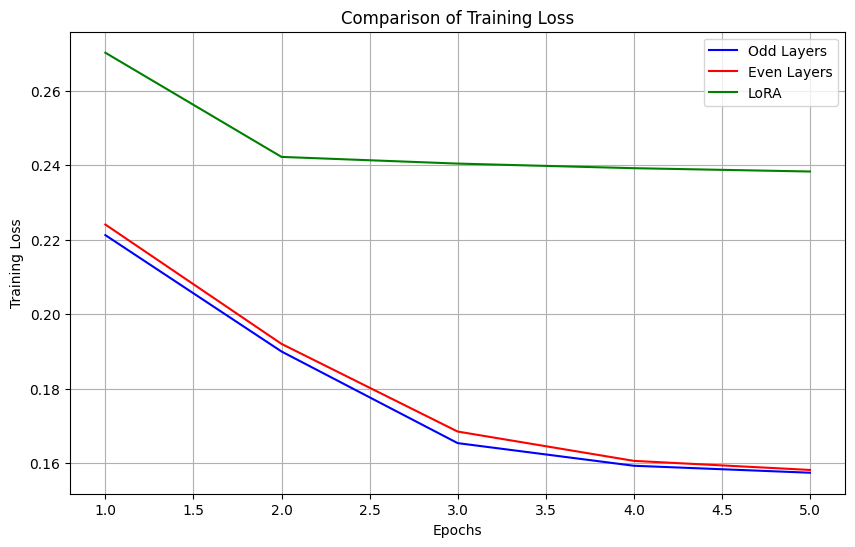

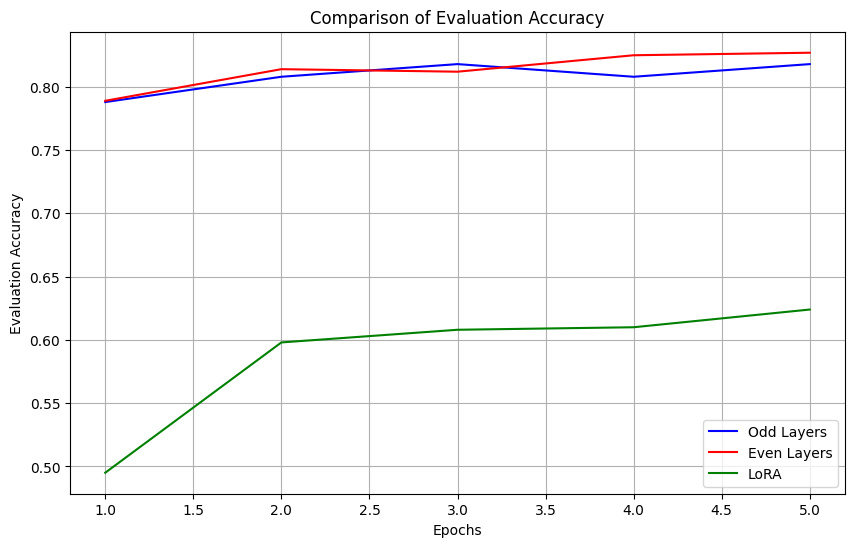


Final Results:
Odd Layer Model - Loss: 0.1575
Even Layer Model - Loss: 0.1582
LoRA Model - Loss: 0.2383

Odd Layer Model - Final Accuracy: 0.8180
Even Layer Model - Final Accuracy: 0.8270
LoRA Model - Final Accuracy: 0.6240

Parameter Counts:
Teacher Model: 109,483,778
Odd/Even Layer Models: 66,956,546
LoRA Model: 296,450


In [22]:
# Plotting function to compare results
import matplotlib.pyplot as plt

def plot_comparison(odd_metrics, even_metrics, lora_metrics, metric_name):
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    
    plt.plot(epochs, odd_metrics, 'b-', label='Odd Layers')
    plt.plot(epochs, even_metrics, 'r-', label='Even Layers')
    plt.plot(epochs, lora_metrics, 'g-', label='LoRA')
    
    plt.title(f'Comparison of {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot training losses
plot_comparison(odd_losses, even_losses, lora_losses, "Training Loss")

# Plot evaluation accuracies
plot_comparison(odd_accuracies, even_accuracies, lora_accuracies, "Evaluation Accuracy")

# Print final results
print("\nFinal Results:")

print(f"Odd Layer Model - Loss: {odd_losses[-1]:.4f}")
print(f"Even Layer Model - Loss: {even_losses[-1]:.4f}")
print(f"LoRA Model - Loss: {lora_losses[-1]:.4f}")

print(f"\nOdd Layer Model - Final Accuracy: {odd_accuracies[-1]:.4f}")
print(f"Even Layer Model - Final Accuracy: {even_accuracies[-1]:.4f}")
print(f"LoRA Model - Final Accuracy: {lora_accuracies[-1]:.4f}")

# Calculate and print parameter counts
print("\nParameter Counts:")
print(f"Teacher Model: {count_parameters(teacher_model):,}")
print(f"Odd/Even Layer Models: {count_parameters(model_odd):,}")
print(f"LoRA Model: {count_parameters(model_lora):,}")

In [ ]:
# Save every models for inference
teacher_model.save_pretrained("teacher_model")
model_odd.save_pretrained("model_odd")
model_even.save_pretrained("model_even")
model_lora.save_pretrained("model_lora")
tokenizer.save_pretrained("teacher_model")
tokenizer.save_pretrained("model_odd")
tokenizer.save_pretrained("model_even")
tokenizer.save_pretrained("model_lora")